In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import myRC
import sys
import math
import scipy.interpolate as scInterp
from scipy.stats.distributions import chi2 as scipy_chi2
from lmfit import Model, Parameters, models
from lmfit.models import SkewedGaussianModel
from datetime import datetime


def interp_models(parameter, chi2_array):
    # make array with the minima of the parameter (unique values)
    param_u = np.unique(parameter)
    param_chi = []
    # if the parameter was not explored:

    if len(param_u) < 3:
        print("Too few values to interpolate.")
        param_chi, param_arr, param_interp = np.nan, np.nan, np.nan
    # interpolate between the minimum chi2 of the different models
    else:
        # get chi2 for the minima
        for i in range(len(param_u)):
            param_chi.append(np.min(chi2_array[parameter == param_u[i]]))

        # interpolate chi2 minima
        interp = scInterp.interp1d(param_u, param_chi, kind='cubic',
                                   fill_value="extrapolate")
        # make finer grid of parameter to interpolate minima on
        min, max = np.min(param_u), np.max(param_u)  # + 0.01*np.min(param_u)
        step = (param_u[1]-param_u[0]) / 10
        param_arr = np.arange(min, max, step)

        # map minima to new array
        param_interp = interp(param_arr)
    return param_u, param_chi, param_arr, param_interp


def get_errs(param_arr, param_interp, conf_level, val_min):
    # intersection between the curves
    idxs = np.argwhere(np.diff(np.sign(param_interp - conf_level))).flatten()
    if len(idxs) == 0:
        print("No errors could be determined.")
        err_l = np.nan
        err_u = np.nan

    elif len(idxs) == 1:
        print("Only one error determined")
        # intersection exactly the same as value => no error
        if param_arr[idxs] == val_min:
            err_u = np.nan
            err_l = np.nan
        if param_arr[idxs] < val_min:
            err_l = val_min - param_arr[idxs][0]
            err_u = np.nan
        elif param_arr[idxs] > val_min:
            err_u = param_arr[idxs][0] - val_min
            err_l = np.nan

    elif len(idxs) == 2:
        err_l = abs(val_min - param_arr[idxs[0]])
        err_u = abs(param_arr[idxs[1]] - val_min)

    elif len(idxs) > 2:
        # more that one interception with conf level => lowest and highest
        err_l = abs(val_min - param_arr[idxs[0]])
        err_u = abs(param_arr[idxs[-1]] - val_min)
    else:
        print("Error determination went somehow wrong")
        err_l = np.nan
        err_u = np.nan

    return(err_l, err_u)

def parab(x, a, h, k):
    "Parabola, center = (h, k)"
    return a*(x-h)**2 + k

def skewedG0(xlist, amp, cen, sig, gam):
    return [amp * np.exp(-(x-cen)**2 / (2*sig**2)) * (1 + math.erf(gam*(x-cen)/(sig*np.sqrt(2)))) / (sig*np.sqrt(2*np.pi)) for x in xlist]

#def skewedG(x, amp, cen, sig, gam, h):
#    return [h - amp * np.exp(-(t-cen)**2 / (2*sig**2)) * (1 + math.erf(gam*(t-cen)/(sig*np.sqrt(2))))  / (sig*np.sqrt(2*np.pi)) for t in x]

def skewedG(x, amp, cen, sig, gam, h):
    return [h - amp * np.exp(-(t-cen)**2 / (2*sig**2)) * (1 + math.erf(gam*(t-cen)/(sig*np.sqrt(2)))) for t in x]


def parab_interc(y, a, h, k):
    "return x-value for certain y"
    return h-np.sqrt((y-k)/a), h+np.sqrt((y-k)/a)

def fit_parab(x, y, a , h, k):
    pars = Parameters()
    pbol = Model(parab)
    pars.update(pbol.make_params())
    pars['a'].set(a, min=0)
    pars['h'].set(h, min=0)
    pars['k'].set(k, min=0)
    mod = pbol
    results = mod.fit(y, pars, x=x)
    return results

def fit_skewG(x, y, amp, cen, gam, h):
    pars = Parameters()
    skG = Model(skewedG)
    pars.update(skG.make_params())
    
    
    #pars['amp'].set(amp, min=500)
    pars['cen'].set(cen, vary=True)
    #pars['sig'].set(cen*0.5, min=0)
    pars['gam'].set(gam)

    pars['amp'].set(amp, min=0)
    #pars['cen'].set(cen, min=cen*0.8, max=cen*1.2)
    #pars['cen'].set(cen, vary=False)
    pars['sig'].set(cen*0.5, min=0)
    #pars['gam'].set(gam, min=gam-np.abs(gam*2), max=gam+np.abs(gam*2))
    pars['h'].set(h, min=0)
    mod = skG
    results = mod.fit(y, pars, x=x)
    return results

def get_interc(x_fit, y_fit, conf_level):
    y_min = min(y_fit)
    idmin = np.where(y_fit==y_min)
    x_min = x_fit[idmin].item()
    idxs = np.argwhere(np.diff(np.sign(y_fit - conf_level))).flatten()
    err_l = abs(x_min - x_fit[idxs[0]])
    err_u = abs(x_fit[idxs[1]] - x_min)
    return x_fit[idmin].item(), err_l, err_u
    

In [76]:
print(get_interc(x_parab, y_parab, conf_level))

0.384909090909091
(0.384909090909091, 0.041818181818181865, 0.029272727272727228)


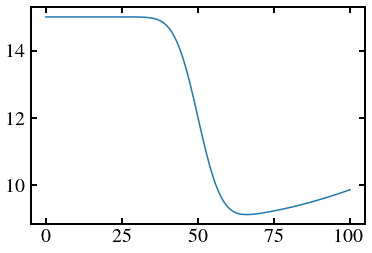

In [181]:
xvals = np.linspace(0, 100, 100)
#yvals0 = skewedG0(xvals, 2, 50, 10, 10)
yvals = skewedG(xvals, 3, 50, 90, 15, 15)
#plt.plot(xvals, yvals0)
plt.plot(xvals, yvals)

In [85]:
tab_file1 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-01.csv'
tab_file2 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-02_negative.csv'
tab_file3 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-02_extra-lrat.csv'
tab_file4 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-02_extra-He2H.csv'
tab_file5 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-03_extra-TeffB.csv'
tab_file6 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-03_rotB500_missing.csv'
tab_file7 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-03_he2h0.14.csv'
tab_file8 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-03_extra-TeffA.csv'
tab_file9 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-04_extra-rotA.csv'

dof = 2100-7
secondary=True
#params='vary'

tab_in1 = pd.read_csv(tab_file1)
tab_in2 = pd.read_csv(tab_file2)
tab_in3 = pd.read_csv(tab_file3)
tab_in4 = pd.read_csv(tab_file4)
tab_in5 = pd.read_csv(tab_file5)
tab_in6 = pd.read_csv(tab_file6)
tab_in7 = pd.read_csv(tab_file7)
tab_in8 = pd.read_csv(tab_file8)
tab_in9 = pd.read_csv(tab_file9)

tab_in8['loggA'].replace([22.5, 27.5], [22, 28], inplace=True)
#tab_in8 = tab_in8[(~tab_in8['loggA'].isin([25, 30])) ]
tab_in8 = tab_in8[(~tab_in8['loggA'].isin([25, 30])) & (tab_in8['TeffA']!=16)]

# tab_in4 = tab_in4[tab_in4['rotB']!=500]
# tab_in = pd.concat([tab_in1, tab_in2])
tab_inA = pd.concat([tab_in1, tab_in2], ignore_index=True)
tab_inB = pd.concat([tab_in3, tab_in4], ignore_index=True)
tab_inC = pd.concat([tab_in5, tab_in6], ignore_index=True)
tab_inD = pd.concat([tab_in7, tab_in8], ignore_index=True)
tab_inAB = pd.concat([tab_inA, tab_inB], ignore_index=True)
tab_inCD = pd.concat([tab_inC, tab_inD], ignore_index=True)
tab_in = pd.concat([tab_inAB, tab_inCD], ignore_index=True)
tab_in = pd.concat([tab_in, tab_in9], ignore_index=True)
# display(tab_in)

# remove chi2 values < 0
# tab = tab_in[tab_in['chi2']>=0]
tab = tab_in[(tab_in['chi2']>=0) & (tab_in['loggA']!=19) & (tab_in['He2H']!=0.8)]
# tab = tab_in[(tab_in['chi2']>=0) & (tab_in['rotB']<500) & (tab_in['loggA']!=19)]
tab = tab[~tab['He2H'].isin([0.065, 0.075, 0.085, 0.09, 0.095])]
#tab = tab[~tab['TeffB'].isin([16, 20])]
#tab = tab[tab['TeffB'] != 16]

In [86]:
# read in unscaled chi2
unscaled_chi2 = tab['chi2']

# renormalize the chi2 such that the best fit corresponds to a chi2 = dof
# which is similar to setting the reduced chi2 =1
chi2 = unscaled_chi2 / unscaled_chi2.min() * dof

# get confidence level
conf_level = scipy_chi2.ppf(0.95, dof)

teffA, loggA, rotA = tab['TeffA'], tab['loggA']/10, tab['rotA']
teffB, loggB, rotB = tab['TeffB'], tab['loggB']/10, tab['rotB']
lrat, he2h = tab['lrat'], tab['He2H']

# pars = [lrat, he2h, teffA, loggA, rotA, teffB, loggB, rotB]
pars = [lrat, he2h, teffA, loggA, teffB, loggB, rotA, rotB]

# get minimum of chi2
idx_min = chi2.idxmin()

# interpolate between the minima
print('Your best fit is:')
pars_min = []
fit_pars = []
results = []
x_vals, y_vals = [], []
gammas = [-10, 8, 10, -0.1, -2, 7, 0.1, 8]
for par, gamm in zip(pars, gammas):
    print(par.name, gamm)
    par_i, par_chi, par_arr, par_interp = interp_models(par, chi2)
    pars_min.append([par_i, par_chi])
    # get best-fit value with respective errors
    par_val = par[idx_min]
    par_l, par_u = get_errs(par_arr, par_interp, conf_level, par_val)
    if par.name in ['TeffA', 'TeffB']:
        par_l, par_u = round(par_l, 2), round(par_u, 2)
    
    
    # fit parabola
#     a = (par_arr[-1]-par_arr[0])/10
    
    h = par_val
    k = max(chi2)
    x_vals.append(par_i)
    y_vals.append(par_chi)
    # fit_skewG(x, y, amp, cen, gam, h)
    fit_res = fit_skewG(par_i, par_chi, 50000, h, gamm, k)
    results.append(fit_res)
    print(fit_res.fit_report(), '\n')
    #print(fit_res.best_values, '\n')
    fit_pars.append(fit_res.best_values)
    #intercept = parab_interc(conf_level, fit_res.best_values['a'], fit_res.best_values['h'], fit_res.best_values['k'])
#     print(intercept)
    # Print the best fit paramters
#     print(par_interp)
#     print(conf_level)
    value = fit_res.best_values['cen']
    #error = value - intercept[0]
    #print(' '+par.name+' = '+f'{value:.2f}'+' +/- '+f'{error:.2f}')

Your best fit is:
lrat -10
[[Model]]
    Model(skewedG)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8340
    # data points      = 6
    # variables        = 5
    chi-square         = 741.328211
    reduced chi-square = 741.328211
    Akaike info crit   = 38.9001039
    Bayesian info crit = 37.8589013
[[Variables]]
    amp:  12020.0624 +/- 22000.7689 (183.03%) (init = 50000)
    cen:  0.62649272 +/- 0.18131748 (28.94%) (init = 0.4)
    sig:  0.80712978 +/- 0.94850668 (117.52%) (init = 0.2)
    gam: -7.07334697 +/- 4.64916190 (65.73%) (init = -10)
    h:    24671.0016 +/- 42700.6641 (173.08%) (init = 1.757708e+08)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, h)   =  1.000
    C(amp, cen) =  1.000
    C(sig, h)   =  1.000
    C(cen, h)   =  1.000
    C(amp, sig) =  1.000
    C(cen, sig) =  0.999
    C(sig, gam) = -0.996
    C(gam, h)   = -0.995
    C(amp, gam) = -0.994
    C(cen, gam) = -0.992 

He2H 8
[[Model]]
    Model(skewedG)
[[F

In [281]:
# condi = (tab['lrat'] == 0.4) & (tab['He2H'] == 0.08) & (tab['TeffA'] == 13) & (tab['loggA'] == 24) & \
#        (tab['rotA'] == 35) & (tab['TeffB'] == 30) & (tab['loggB'] == 35)  & (tab['rotB'] == 200 )
condi = (tab['TeffB'] == 16) #& (tab['rotB'] == 100)# & (tab['loggB'] == 40)
# condi = (tab['TeffB'] == 30) & (tab['loggB'] == 35)  & (tab['rotB'] == 200 )
# display(tab[condi].sort_values(by=['lrat', 'He2H', 'TeffA', 'loggA', 'rotA', 'TeffB', 'loggB', 'rotB', 'chi2']))
# display(tab.sort_values(by=['chi2'])[:15])
display(tab.sort_values(by=['chi2'])[:15])

,lrat,He2H,TeffA,loggA,rotA,TeffB,loggB,rotB,chi2,chi2A,chi2B,red_chi2,red_chi2A,red_chi2B
1368726,0.40,0.10,13,24.0,35,16.0,25.0,300,0.590307,0.309208,0.281098,0.000569,0.000271,0.000298
1368727,0.40,0.10,13,24.0,30,16.0,25.0,300,0.594468,0.313370,0.281098,0.000572,0.000274,0.000298
1368729,0.40,0.10,13,24.0,40,16.0,25.0,300,0.598181,0.317082,0.281098,0.000576,0.000277,0.000298
1368731,0.40,0.10,13,24.0,35,16.0,25.0,200,0.609694,0.309208,0.300485,0.000589,0.000271,0.000319
1368732,0.40,0.10,13,24.0,35,20.0,27.5,300,0.612745,0.309208,0.303537,0.000592,0.000271,0.000322
1368733,0.40,0.10,13,24.0,30,16.0,25.0,200,0.613855,0.313370,0.300485,0.000593,0.000274,0.000319
1368734,0.40,0.10,13,24.0,30,20.0,27.5,300,0.616907,0.313370,0.303537,0.000596,0.000274,0.000322
1368735,0.40,0.10,13,24.0,40,16.0,25.0,200,0.617568,0.317082,0.300485,0.000596,0.000277,0.000319
1622652,0.35,0.08,14,24.0,40,16.0,27.5,200,0.618753,0.282157,0.336595,0.000604,0.000247,0.000357
1622653,0.35,0.08,14,24.0,35,16.0,27.5,200,0.619833,0.283238,0.336595,0.000605,0.000248,0.000357


L_rat = 0.38$^{+0.03}_{-0.04}$
He/H = 0.11$^{+0.02}_{-0.02}$
$T_{\text{eff}, A}$ = 13.15$^{+1.17}_{-0.87}$
$\log g_A$ = 2.39$^{+0.16}_{-0.16}$
$T_{\text{eff}, B}$ = 16.09$^{+9.13}_{-0.12}$
$\log g_B$ = 2.78$^{+0.44}_{-0.44}$
$\varv \sin i_A$ = 35.26$^{+12.29}_{-12.54}$
$\varv\sin i_B$ = 250.39$^{+173.09}_{-61.44}$


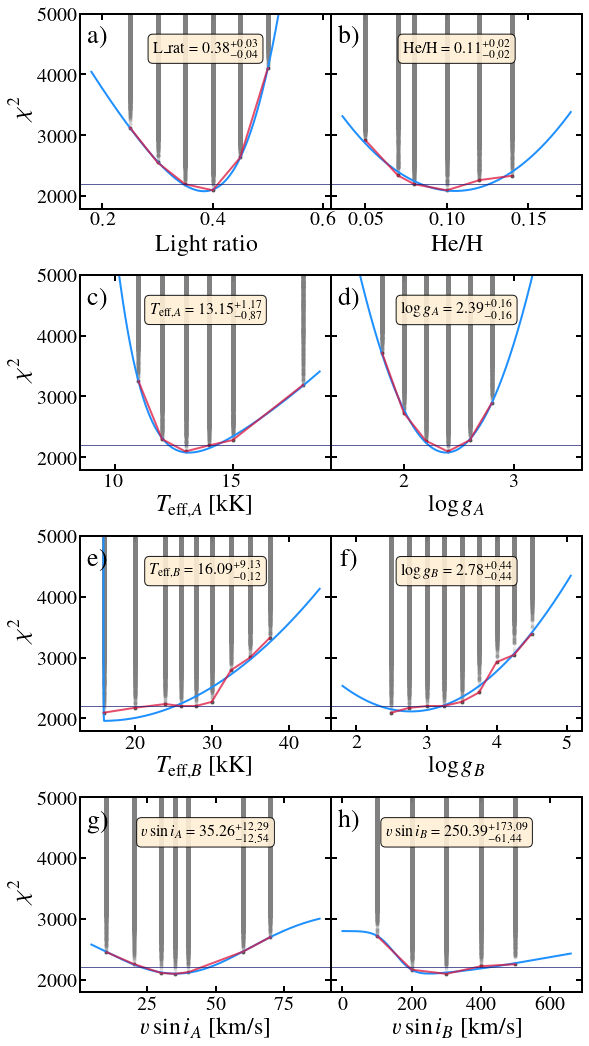

In [123]:
#labels= [ r'L_rat = 0.36 $\pm$ 0.05', r'He/H = 0.11 $\pm$ 0.03', r'$T_{\text{eff}, A}$ = 13.86 $\pm$ 1.25 kK', \
#        r'$\log g_A$ = 2.43 $\pm$ 0.21', r'$T_{\text{eff}, B}$ = 24.67 $\pm$ 4.19 kK', r'$\log g_B$ = 3.32 $\pm$ 0.30', \
#        r'$\varv \sin i_A = 33.0 \pm 17.5$ km/s', r'$\varv\sin i_B = 338 \pm 121$ km/s']

labels= [ r'L_rat', r'He/H', r'$T_{\text{eff}, A}$', r'$\log g_A$', 
          r'$T_{\text{eff}, B}$', r'$\log g_B$', r'$\varv \sin i_A$', r'$\varv\sin i_B$']

x_labels = ['Light ratio', 'He/H', r'$T_{\text{eff}, A}$ [kK]', r'$\log g_A$', r'$T_{\text{eff}, B}$ [kK]', \
        r'$\log g_B$', r'$\varv \sin i_A$ [km/s]', r'$\varv \sin i_B$ [km/s]']
props = dict(boxstyle='round', facecolor='papayawhip', alpha=0.9)
vmin, vmax = min(chi2), 2.*conf_level
pars_limits =[[0.2, 0.54], [0.04, 0.16], [10, 17], [1.6, 3.2], [16, 40], [2, 4.6], [5, 80], [0, 600]]
panels_id = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9*1, 9*2), sharey=True)
fig.subplots_adjust(wspace=0., hspace=0.34)
ax = axes.flatten()
for i, par, minval in zip(range(len(pars)), pars, pars_min):
    ax[i].plot(par, chi2, ls='None', marker='.', c='grey', alpha=0.1)
    ax[i].plot(pars_min[i][0], pars_min[i][1], 'k.', alpha=0.5)
#     x_parab = np.linspace(pars_min[i][0][0], pars_min[i][0][-1], 100)
    #x_parab = np.linspace(pars_limits[i][0], pars_limits[i][1], 100)
    x_parab = np.linspace(pars_limits[i][0]*0.9, pars_limits[i][1]*1.1, 1000)
    y_parab = skewedG(x_parab, fit_pars[i]['amp'], fit_pars[i]['cen'], fit_pars[i]['sig'], fit_pars[i]['gam'], fit_pars[i]['h'])
    par_val, par_ler, par_uer = get_interc(x_parab, y_parab, conf_level)
    #label = par.name+' = '+f'{par_val:.2f}'+' + '+f'{par_uer:.2f}'+' - '+f'{par_ler:.2f}'
    label = labels[i]+' = '+f'{par_val:.2f}'+r'$^{+'+f'{par_uer:.2f}'+'}'+r'_{-'+f'{par_ler:.2f}'+'}$'
    print(label)
    ax[i].plot(x_parab, y_parab, lw=2, c='dodgerblue')
    #ax[i].plot(x_vals[i], results[i].best_fit, lw=2, c='dodgerblue')
#     ax[7].plot(rotA, chi2, 'k.', alpha=0.5)
#     ax[7].set_xlabel('rotA')
    ax[i].plot(minval[0], minval[1], 'crimson', lw=2, alpha=.75)
    ax[i].axhline(conf_level, color='midnightblue', lw=1, alpha=0.7)
    # ax[i].set_title(par.name)
    ax[i].set_xlabel(x_labels[i])
    if i in [0, 2, 4, 6]:
        ax[i].set_ylabel(r'$\chi^2$')
    ax[i].text(0.5, 0.8, label, fontsize=16, horizontalalignment='center', transform = ax[i].transAxes, bbox=props)
    ax[i].text(0.07, 0.84, panels_id[i], fontsize=26, horizontalalignment='center', transform = ax[i].transAxes)
ax[0].set_ylim(vmin-300, 5000)

# plt.savefig('errors_paper.pdf', bbox_inches='tight')
plt.savefig('errors_paper_2.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


{'amp': 12019.346208286544, 'cen': 0.6264868212993496, 'sig': 0.8070988736635738, 'gam': -7.073195675188706, 'h': 24669.611285797535}


(1500.0, 6000.0)

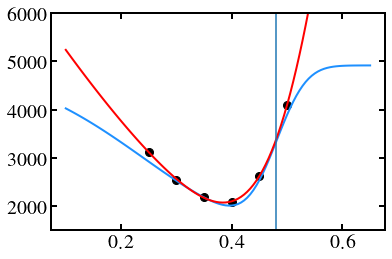

In [24]:
print(results[0].best_values)
best_val = [results[0].params[par].value for par in results[0].var_names]

plt.plot(x_vals[0], y_vals[0], 'ok', ms=8)
#plt.axis([0.1, 0.65, 1000, 5000])
x_parab = np.linspace(0.1, 0.65, 100)
y_parab = skewedG(x_parab, 1587.48,  0.4799, 0.2381,  -5.4448, 4915.8931)
plt.plot(x_parab, y_parab, lw=2, c='dodgerblue')

y_parab2 = skewedG(x_parab, best_val[0], best_val[1], best_val[2], best_val[3], best_val[4])
plt.plot(x_parab, y_parab2, lw=2, c='red')
plt.axvline(0.4799)
plt.ylim(1500, 6000)

{'amp': 555788.4356848871, 'cen': 0.0924719835426103, 'sig': 1.0372168319138346, 'gam': 0.015206297436603919, 'h': 557911.341699733}


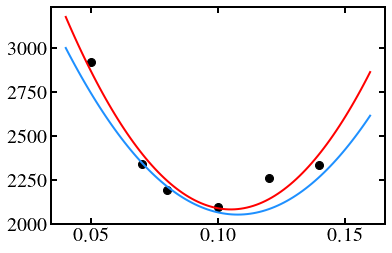

In [25]:
print(results[1].best_values)
best_val = [results[1].params[par].value for par in results[1].var_names]

plt.plot(x_vals[1], y_vals[1], 'ok', ms=8)
#plt.axis([0.1, 0.65, 1000, 5000])
x_parab = np.linspace(0.04, 0.16, 100)
y_parab = skewedG(x_parab, 230310.7068,  0.080, 0.7481,  0.04662, 232522.5169)
plt.plot(x_parab, y_parab, lw=2, c='dodgerblue')

y_parab2 = skewedG(x_parab, best_val[0], best_val[1], best_val[2], best_val[3], best_val[4])
plt.plot(x_parab, y_parab2, lw=2, c='red')

{'amp': 41817.68268035666, 'cen': 5.827510441325815, 'sig': 55.59876750838577, 'gam': 22.014805593079384, 'h': 84832.66975155589}
[41817.68268035666, 5.827510441325815, 55.59876750838577, 22.014805593079384, 84832.66975155589]


(1500.0, 4000.0)

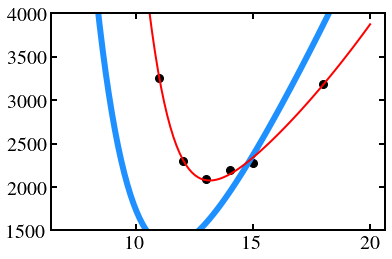

In [26]:
print(results[2].best_values)
best_val = [results[2].params[par].value for par in results[2].var_names]
print(best_val)
plt.plot(x_vals[2], y_vals[2], 'ok', ms=8)
#plt.axis([0.1, 0.65, 1000, 5000])
x_parab = np.linspace(7, 20, 100)

y_parab = skewedG(x_parab, 4309031.199496073, -10.481377703310667, 673.3054251720324, 117.07630264425323, 8614220.83954351)
plt.plot(x_parab, y_parab, lw=6, c='dodgerblue')

y_parab2 = skewedG(x_parab, best_val[0], best_val[1], best_val[2], best_val[3], best_val[4])
plt.plot(x_parab, y_parab2, lw=2, c='red')
plt.ylim(1500, 4000)

{'amp': 78142.03120898819, 'cen': -0.3249072999727749, 'sig': 0.06459935136920869, 'gam': 3.523298143887744, 'h': 2662.456813371667}
[78142.03120898819, -0.3249072999727749, 0.06459935136920869, 3.523298143887744, 2662.456813371667]


(1500.0, 4000.0)

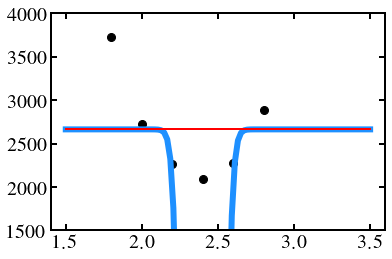

In [30]:
print(results[3].best_values)
best_val = [results[3].params[par].value for par in results[3].var_names]
print(best_val)
plt.plot(x_vals[3], y_vals[3], 'ok', ms=8)
#plt.axis([0.1, 0.65, 1000, 5000])
x_parab = np.linspace(1.5, 3.5, 100)

y_parab = skewedG(x_parab, 78142.03120898819, 2.4, 0.06459935136920869, 0, 2662.456813371667)
plt.plot(x_parab, y_parab, lw=6, c='dodgerblue')

y_parab2 = skewedG(x_parab, best_val[0], best_val[1], best_val[2], best_val[3], best_val[4])
plt.plot(x_parab, y_parab2, lw=2, c='red')
plt.ylim(1500, 4000)

(array([0.00487622, 0.00243811, 0.02438108, 0.03657162, 0.14141025,
        0.27306806, 0.36571615, 0.66072718, 0.74362285, 0.18529618]),
 array([-3.80224711, -3.39209295, -2.9819388 , -2.57178464, -2.16163049,
        -1.75147633, -1.34132218, -0.93116802, -0.52101387, -0.11085971,
         0.29929444]),
 [<matplotlib.patches.Polygon at 0x7f439d7a2510>])

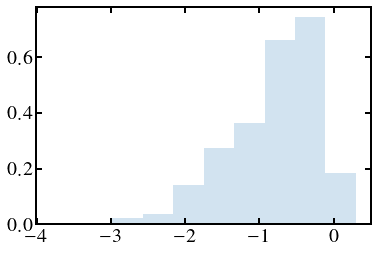

In [122]:
from scipy.stats import skewnorm
rdm_skew = skewnorm.rvs(-7.07, size=1000)
plt.hist(rdm_skew, density=True, histtype='stepfilled', alpha=0.2)